# Present Wrapping Problem

The PWP can be seen as a specialization of the more general rectangle packing problem, in which we have a set of rectangles (our presents) of given dimensions that have to fit into a pre-determined square (the wrapping paper) of a given size. The great thing about PWP is that we kwow the items will perfectly fit into the given container, without any kind of wasted space.

We decided to use a list of bottom left corners (with the same index set as the list of presents shapes) as the solution representation. So, the main constraint we have dealt with are the following ones:
* Rectangles cannot overlap
* Rectangles should be completely contained inside the wrapping paper
* No wasted paper
* Rectangles cannot be rotated (unless specified)

In [2]:
%load_ext autoreload
%load_ext iminizinc
%matplotlib inline
%autoreload 2

import string
import random
from time import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from z3 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


## Functions

This section contains different utility functions, needed to deal with instances input/output, results handling (solutions graphical representation and running time plots), ...

In [3]:
def rand_str(size=10, chars=string.ascii_uppercase + string.digits):
    '''
    Returns a string of the given length with randomly chosen characters
    '''
    return ''.join(random.choice(chars) for _ in range(size))

In [4]:
def read_input(path):
    '''
    Read the given input instance, which should have the following format:

    W H
    N
    P1X P1Y
    ...
    PNX PNY

    Here, PIJ means present I, coordinate J, while W and H are the paper's dimensions
    '''
    file = open(path, "r").readlines()
    w_paper , h_paper = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n = int(file[1].rstrip("\n"))
    presents = []
    for i in range(2, n + 2):
        presents.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return w_paper, h_paper, n, presents

In [5]:
def show_solutions(w_paper, h_paper, n, presents, solutions, model):
    '''
    Show each and every solution as 2D plots
    '''
    if not isinstance(solutions,list):
        solutions = [solutions]

    colors = np.random.rand(n, 3)
    for solution in solutions:
        show_solution(w_paper, h_paper, n, presents, solution, model, colors)

def show_solution(w_paper, h_paper, n, presents, solution, model, colors=None):
    '''
    Show the given solution as a 2D plot. 
    The solution should be a list of bottom left corners, 
    contained in the given w_paper and h_paper margins
    '''
    assert(isinstance(w_paper, int))
    assert(isinstance(h_paper, int))
    assert(isinstance(presents, list))
    assert(isinstance(n, int) and n == len(presents))
    assert(isinstance(solution, dict))
    assert('bl_corners' in solution)
    assert(len(presents) == len(solution['bl_corners']))

    bl_corners = solution['bl_corners']
    if 'kind' in solution:
        for i in range(n):
            if solution['kind'][i] % 2 == 0:
                presents[i][1], presents[i][0] = presents[i][0], presents[i][1]

    if colors is None:
        colors = np.random.rand(n, 3)
    fig, ax = plt.subplots()
    for i in range(n):
        ax.add_patch(patches.Rectangle(
            bl_corners[i],
            presents[i][0],
            presents[i][1],
            facecolor=colors[i]
        ))
    ax.set_xlim(0, w_paper)
    ax.set_ylim(0, h_paper)
    print(f"Solution: {bl_corners}")
    plt.show()
    output(w_paper, h_paper, n, presents, bl_corners, model)

In [6]:
def show_running_times(instances, times):
    '''
    Show instance size versus running time plot
    '''
    fig = plt.figure(figsize=(12, 8), dpi= 100, facecolor='w', edgecolor='k')
    plt.xlabel("Instance")
    plt.ylabel("Total running time")
    plt.plot(instances, times, marker='o', linestyle='dashed', linewidth=2, markersize=12)
    plt.show()

In [7]:
def order_presents(presents, method='height', reverse=False):
    '''
    Order presents, increasing or decreasing, 
    by the given method (area, height, width)
    '''
    to_sort = (
        [e[0] * e[1] for e in presents] if method == 'area'
        else [e[1] for e in presents] if method == 'height'
        else [e[0] for e in presents] if method == 'width'
        else None
    )
    sorted_indices = sorted(range(len(to_sort)), key=lambda k: to_sort[k], reverse=reverse)
    presents = [presents[i] for i in sorted_indices]
    return presents, sorted_indices

In [8]:
def output(w_paper, h_paper, n, presents, bl_corners, model):
    '''
    Write the given solution to an output file, in a specific output folder,
    with the following format:
    
    W H
    N
    P1X P1Y  C1X C1Y
    ...
    PNX PNY  CNX CNY

    Here, PIJ means present I, coordinate J; 
    CIJ means coordinate J of the bottom left corner of present I; 
    while W and H are the paper's dimensions
    '''
    out_file = open(f"out/{model}/{w_paper}x{h_paper}-out.txt", "w+")
    print(f"{w_paper} {h_paper}", file=out_file)
    print(f"{n}", file=out_file)
    for present, position in zip(presents, bl_corners):
        present_x, present_y = present
        position_x, position_y = position
        print(f"{present_x} {present_y}{2 * ' '}{position_x} {position_y}", file=out_file)
    out_file.close()

## CP

In this section, we reported various CP models, in which we tried different approaches, evolving from one another on the basis of references and own ideas. Some of them tend to be faster in a specific subset of instances, w.r.t. the others. In the final model, we tried to put together the different key-points of each model.

CP models are implemented with the MiniZinc language and models execution is managed by the official MiniZinc Jupyter extension, called iMiniZinc.

### Input

The following subsection is dedicated to input handling. In particular, if we want to test a single instance, we can set the `instance` variable and execute the code below to visualize one associated solution. If instead we want to test every single instance, we can just set the `instance` variable to the special value `None` and still execute the code below to both visualize every computed solution and analyze running times for every instance.

In [112]:
instance = None
min_instance, max_instance = 8, 40

Paper dimensions: 8x8
Presents dimensions: [[3, 3], [3, 5], [5, 3], [5, 5]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatIntVars=20
mzn-stat: flatIntConstraints=7
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.120696
mzn-stat-end
mzn-stat: initTime=0.001
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=52
mzn-stat: propagators=0
mzn-stat: propagations=5
mzn-stat: nodes=1
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=0
mzn-stat-end
Solution: [[5, 5], [5, 0], [0, 5], [0, 0]]


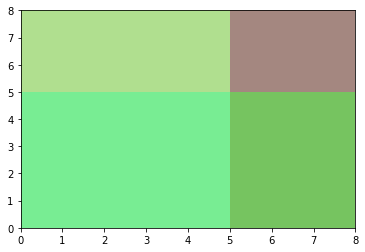


Paper dimensions: 9x9
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=142
mzn-stat: flatIntVars=80
mzn-stat: flatBoolConstraints=67
mzn-stat: flatIntConstraints=197
mzn-stat: evaluatedReifiedConstraints=17
mzn-stat: evaluatedHalfReifiedConstraints=142
mzn-stat: eliminatedImplications=30
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.129337
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=225
mzn-stat: propagators=252
mzn-stat: propagations=545
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
Solution: [[3, 6], [6, 5], [6, 0], [3, 0], [0, 0]]


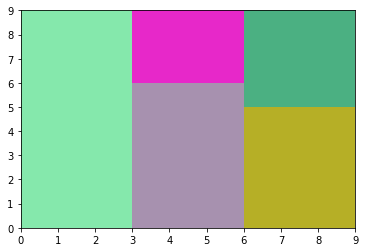


Paper dimensions: 10x10
Presents dimensions: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=109
mzn-stat: flatIntVars=64
mzn-stat: flatBoolConstraints=42
mzn-stat: flatIntConstraints=148
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=103
mzn-stat: eliminatedImplications=12
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.130793
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=189
mzn-stat: propagators=146
mzn-stat: propagations=360
mzn-stat: nodes=2
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
Solution: [[4, 7], [7, 6], [7, 0], [4, 0], [0, 6], [0, 0]]


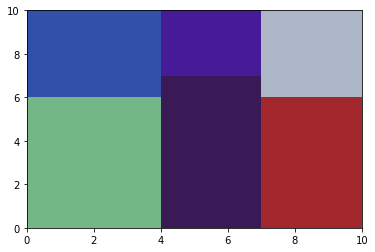


Paper dimensions: 11x11
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=91
mzn-stat: flatIntVars=63
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=147
mzn-stat: evaluatedReifiedConstraints=7
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.124807
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=154
mzn-stat: propagators=164
mzn-stat: propagations=1066
mzn-stat: nodes=26
mzn-stat: failures=9
mzn-stat: restarts=0
mzn-stat: peakDepth=10
mzn-stat-end
Solution: [[5, 8], [5, 4], [8, 6], [8, 0], [0, 8], [0, 4], [0, 0]]


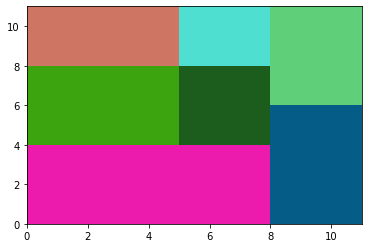


Paper dimensions: 12x12
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=120
mzn-stat: flatIntVars=72
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=183
mzn-stat: evaluatedReifiedConstraints=8
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.12395
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=192
mzn-stat: propagators=193
mzn-stat: propagations=2125
mzn-stat: nodes=34
mzn-stat: failures=13
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[3, 6], [6, 8], [9, 7], [3, 0], [9, 0], [6, 0], [0, 0], [0, 9]]


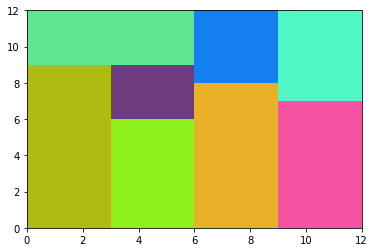


Paper dimensions: 13x13
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=153
mzn-stat: flatIntVars=81
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=223
mzn-stat: evaluatedReifiedConstraints=9
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.128698
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=234
mzn-stat: propagators=251
mzn-stat: propagations=3448
mzn-stat: nodes=102
mzn-stat: failures=46
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[4, 10], [4, 6], [7, 8], [10, 7], [10, 0], [7, 0], [0, 10], [0, 6], [0, 0]]


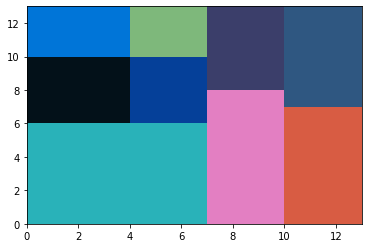


Paper dimensions: 14x14
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=310
mzn-stat: flatIntVars=146
mzn-stat: flatBoolConstraints=140
mzn-stat: flatIntConstraints=408
mzn-stat: evaluatedReifiedConstraints=25
mzn-stat: evaluatedHalfReifiedConstraints=327
mzn-stat: eliminatedImplications=63
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.136228
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=472
mzn-stat: propagators=472
mzn-stat: propagations=1205
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
Solution: [[11, 11], [11, 7], [5, 9], [8, 8], [11, 0], [8, 0], [5, 0], [0, 10], [0, 0]]


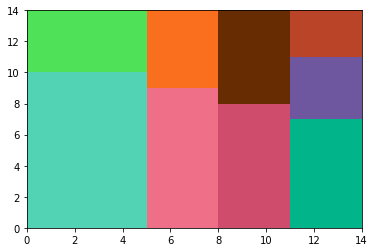


Paper dimensions: 15x15
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=87
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=264
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.12494
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=281
mzn-stat: propagators=275
mzn-stat: propagations=2681
mzn-stat: nodes=77
mzn-stat: failures=33
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[3, 12], [9, 8], [12, 7], [6, 9], [12, 0], [9, 0], [6, 0], [3, 0], [0, 0], [9, 12]]


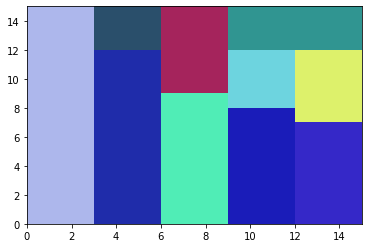


Paper dimensions: 16x16
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=90
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=267
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.12645
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=280
mzn-stat: propagators=284
mzn-stat: propagations=3004
mzn-stat: nodes=88
mzn-stat: failures=39
mzn-stat: restarts=0
mzn-stat: peakDepth=15
mzn-stat-end
Solution: [[13, 13], [7, 12], [13, 8], [10, 10], [4, 9], [13, 0], [10, 0], [7, 0], [0, 9], [0, 0]]


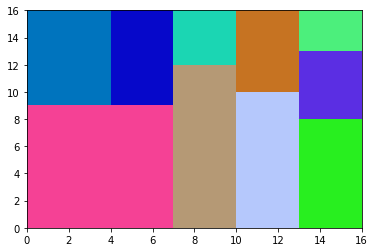


Paper dimensions: 17x17
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=276
mzn-stat: flatIntVars=108
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=367
mzn-stat: evaluatedReifiedConstraints=12
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.135002
mzn-stat-end
mzn-stat: initTime=0.017
mzn-stat: solveTime=0.012
mzn-stat: solutions=1
mzn-stat: variables=384
mzn-stat: propagators=417
mzn-stat: propagations=61172
mzn-stat: nodes=1370
mzn-stat: failures=678
mzn-stat: restarts=0
mzn-stat: peakDepth=26
mzn-stat-end
Solution: [[14, 14], [4, 13], [11, 9], [14, 8], [4, 6], [14, 0], [11, 0], [0, 14], [7, 6], [0, 0], [7, 14], [4, 0]]


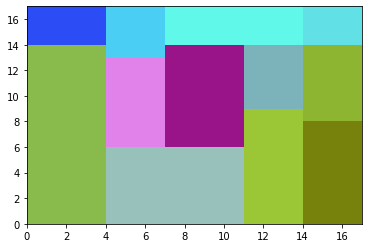


Paper dimensions: 18x18
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=575
mzn-stat: flatIntVars=205
mzn-stat: flatBoolConstraints=224
mzn-stat: flatIntConstraints=702
mzn-stat: evaluatedReifiedConstraints=29
mzn-stat: evaluatedHalfReifiedConstraints=606
mzn-stat: eliminatedImplications=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.156682
mzn-stat-end
mzn-stat: initTime=0.023
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=844
mzn-stat: propagators=706
mzn-stat: propagations=2680
mzn-stat: nodes=8
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end
Solution: [[12, 15], [15, 14], [12, 10], [15, 8], [9, 11], [15, 0], [12, 0], [9, 0], [5, 15], [5, 11], [5, 6], [5, 0], [0, 15], [0, 11], [0, 6], [0, 0]]


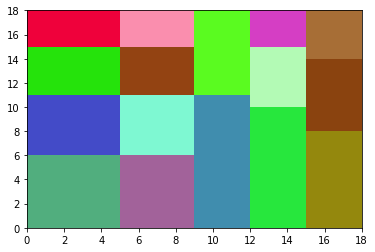


Paper dimensions: 19x19
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=893
mzn-stat: flatIntVars=401
mzn-stat: flatBoolConstraints=468
mzn-stat: flatIntConstraints=1198
mzn-stat: evaluatedReifiedConstraints=61
mzn-stat: evaluatedHalfReifiedConstraints=1056
mzn-stat: eliminatedImplications=275
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.199172
mzn-stat-end
mzn-stat: initTime=0.033
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=1321
mzn-stat: propagators=1502
mzn-stat: propagations=6255
mzn-stat: nodes=10
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=7
mzn-stat-end
Solution: [[16, 16], [13, 15], [13, 10], [7, 13], [16, 9], [10, 11], [16, 0], [13, 0], [10, 0], [7, 0], [4, 0], [0, 14], [0, 8], [0, 0]]


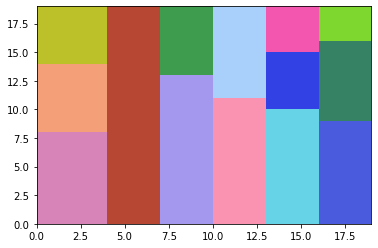


Paper dimensions: 20x20
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=800
mzn-stat: flatIntVars=338
mzn-stat: flatBoolConstraints=379
mzn-stat: flatIntConstraints=1049
mzn-stat: evaluatedReifiedConstraints=56
mzn-stat: evaluatedHalfReifiedConstraints=888
mzn-stat: eliminatedImplications=192
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.17723
mzn-stat-end
mzn-stat: initTime=0.03
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=1138
mzn-stat: propagators=1380
mzn-stat: propagations=3566
mzn-stat: nodes=5
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=4
mzn-stat-end
Solution: [[8, 17], [14, 16], [17, 15], [14, 10], [17, 8], [17, 0], [11, 11], [14, 0], [11, 0], [8, 0], [0, 17], [4, 11], [4, 0], [0, 0]]


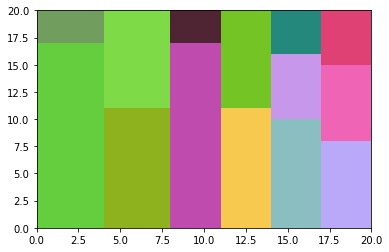


Paper dimensions: 21x21
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=763
mzn-stat: flatIntVars=309
mzn-stat: flatBoolConstraints=355
mzn-stat: flatIntConstraints=983
mzn-stat: evaluatedReifiedConstraints=46
mzn-stat: evaluatedHalfReifiedConstraints=857
mzn-stat: eliminatedImplications=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.179476
mzn-stat-end
mzn-stat: initTime=0.03
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=1112
mzn-stat: propagators=1119
mzn-stat: propagations=3076
mzn-stat: nodes=4
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=3
mzn-stat-end
Solution: [[9, 18], [18, 17], [15, 16], [15, 10], [12, 14], [18, 9], [18, 0], [15, 0], [12, 0], [9, 0], [5, 17], [5, 11], [5, 0], [0, 15], [0, 0]]


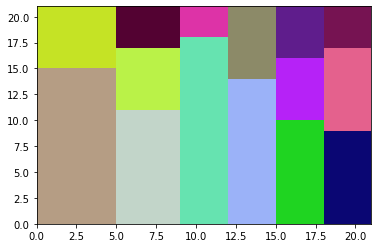


Paper dimensions: 22x22
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=496
mzn-stat: flatIntVars=141
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=612
mzn-stat: evaluatedReifiedConstraints=16
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.135831
mzn-stat-end
mzn-stat: initTime=0.022
mzn-stat: solveTime=0.01
mzn-stat: solutions=1
mzn-stat: variables=642
mzn-stat: propagators=654
mzn-stat: propagations=29313
mzn-stat: nodes=833
mzn-stat: failures=408
mzn-stat: restarts=0
mzn-stat: peakDepth=29
mzn-stat-end
Solution: [[19, 19], [16, 18], [10, 13], [13, 12], [16, 11], [7, 14], [19, 10], [19, 0], [16, 0], [13, 0], [10, 0], [7, 0], [4, 0], [0, 19], [0, 0], [10, 18]]


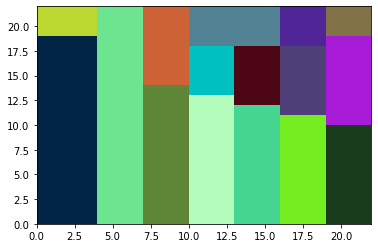


Paper dimensions: 23x23
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]
Error in MiniZinc:
Column stacking: false
%%%mzn-stat: nSolutions=0


Paper dimensions: 24x24
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1168
mzn-stat: flatIntVars=482
mzn-stat: flatBoolConstraints=583
mzn-stat: flatIntConstraints=1534
mzn-stat: evaluatedReifiedConstraints=67
mzn-stat: evaluatedHalfReifiedConstraints=1375
mzn-stat: eliminatedImplications=330
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.234653
mzn-stat-end
mzn-stat: initTime=0.043
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=1701
m

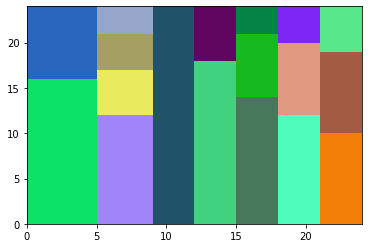


Paper dimensions: 25x25
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=703
mzn-stat: flatIntVars=168
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=840
mzn-stat: evaluatedReifiedConstraints=19
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.150265
mzn-stat-end
mzn-stat: initTime=0.056
mzn-stat: solveTime=0.003
mzn-stat: solutions=1
mzn-stat: variables=876
mzn-stat: propagators=919
mzn-stat: propagations=8882
mzn-stat: nodes=185
mzn-stat: failures=82
mzn-stat: restarts=0
mzn-stat: peakDepth=31
mzn-stat-end
Solution: [[19, 22], [22, 21], [13, 17], [3, 19], [6, 18], [16, 14], [19, 13], [22, 11], [22, 0], [19, 0], [16, 0], [13, 0], [6, 0], [3, 0], [0, 0], [9, 2

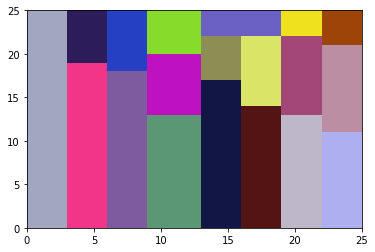


Paper dimensions: 26x26
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2124
mzn-stat: flatIntVars=900
mzn-stat: flatBoolConstraints=1111
mzn-stat: flatIntConstraints=2853
mzn-stat: evaluatedReifiedConstraints=118
mzn-stat: evaluatedHalfReifiedConstraints=2574
mzn-stat: eliminatedImplications=672
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.335342
mzn-stat-end
mzn-stat: initTime=0.07
mzn-stat: solveTime=0.025
mzn-stat: solutions=1
mzn-stat: variables=3024
mzn-stat: propagators=3904
mzn-stat: propagations=64952
mzn-stat: nodes=825
mzn-stat: failures=407
mzn-stat: restarts=0
mzn-stat: peakDepth=45
mzn-stat-end
Solution: [[23, 23], [20, 22], [17, 21], [17, 15], [8, 19], [20, 14], [11, 17], [14, 

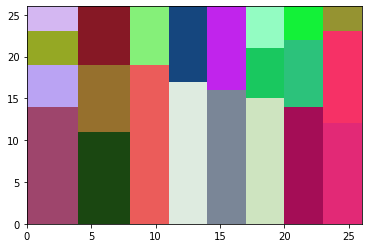


Paper dimensions: 27x27
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1766
mzn-stat: flatIntVars=692
mzn-stat: flatBoolConstraints=862
mzn-stat: flatIntConstraints=2305
mzn-stat: evaluatedReifiedConstraints=102
mzn-stat: evaluatedHalfReifiedConstraints=2049
mzn-stat: eliminatedImplications=474
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.264024
mzn-stat-end
mzn-stat: initTime=0.059
mzn-stat: solveTime=0.009
mzn-stat: solutions=1
mzn-stat: variables=2458
mzn-stat: propagators=3081
mzn-stat: propagations=36197
mzn-stat: nodes=530
mzn-stat: failures=260
mzn-stat: restarts=0
mzn-stat: peakDepth=32
mzn-stat-end
Solution: [[24, 24], [24, 20], [21, 22], [12, 21], [15, 20], [18, 19], [24, 11], [21, 12], [24

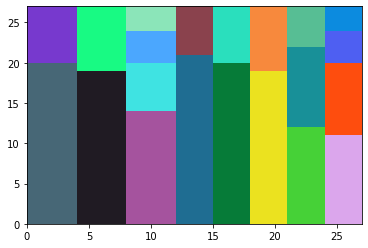


Paper dimensions: 28x28
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1724
mzn-stat: flatIntVars=631
mzn-stat: flatBoolConstraints=802
mzn-stat: flatIntConstraints=2208
mzn-stat: evaluatedReifiedConstraints=89
mzn-stat: evaluatedHalfReifiedConstraints=1978
mzn-stat: eliminatedImplications=420
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.248108
mzn-stat-end
mzn-stat: initTime=0.056
mzn-stat: solveTime=0.003
mzn-stat: solutions=1
mzn-stat: variables=2379
mzn-stat: propagators=2714
mzn-stat: propagations=16872
mzn-stat: nodes=90
mzn-stat: failures=41
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end
Solution: [[25, 25], [22, 24], [13, 23], [25, 19], [16, 21], [22, 16], [25, 10], [25, 0],

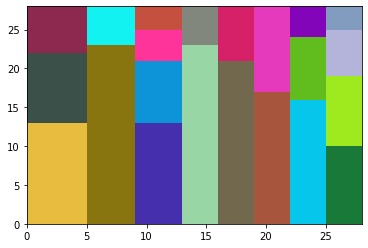


Paper dimensions: 29x29
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1848
mzn-stat: flatIntVars=603
mzn-stat: flatBoolConstraints=795
mzn-stat: flatIntConstraints=2300
mzn-stat: evaluatedReifiedConstraints=89
mzn-stat: evaluatedHalfReifiedConstraints=2056
mzn-stat: eliminatedImplications=372
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.271344
mzn-stat-end
mzn-stat: initTime=0.059
mzn-stat: solveTime=0.031
mzn-stat: solutions=1
mzn-stat: variables=2475
mzn-stat: propagators=2808
mzn-stat: propagations=76321
mzn-stat: nodes=1240
mzn-stat: failures=615
mzn-stat: restarts=0
mzn-stat: peakDepth=43
mzn-stat-end
Solution: [[17, 26], [20, 25], [23, 24], [17, 20], [20, 18], [26, 21],

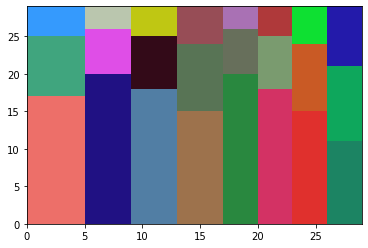


Paper dimensions: 30x30
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1510
mzn-stat: flatIntVars=630
mzn-stat: flatBoolConstraints=770
mzn-stat: flatIntConstraints=2005
mzn-stat: evaluatedReifiedConstraints=79
mzn-stat: evaluatedHalfReifiedConstraints=1816
mzn-stat: eliminatedImplications=455
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.244789
mzn-stat-end
mzn-stat: initTime=0.052
mzn-stat: solveTime=0.007
mzn-stat: solutions=1
mzn-stat: variables=2188
mzn-stat: propagators=2431
mzn-stat: propagations=20439
mzn-stat: nodes=289
mzn-stat: failures=141
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end
Solution: [[18, 27], [21, 26], [15, 25], [27, 24], [24, 23], [18, 19], [24, 14], [21, 16], [27, 13], [2

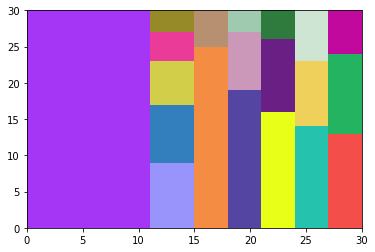


Paper dimensions: 31x31
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1439
mzn-stat: flatIntVars=622
mzn-stat: flatBoolConstraints=751
mzn-stat: flatIntConstraints=1934
mzn-stat: evaluatedReifiedConstraints=79
mzn-stat: evaluatedHalfReifiedConstraints=1749
mzn-stat: eliminatedImplications=455
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.238838
mzn-stat-end
mzn-stat: initTime=0.048
mzn-stat: solveTime=0.007
mzn-stat: solutions=1
mzn-stat: variables=2104
mzn-stat: propagators=2380
mzn-stat: propagations=32635
mzn-stat: nodes=483
mzn-stat: failures=237
mzn-stat: restarts=0
mzn-stat: peakDepth=35
mzn-stat-end
Solution: [[28, 28], [22, 27], [28, 23], [22, 21], [22, 14], [25, 23], [19, 22], [25, 13], [28, 12], [28, 0], 

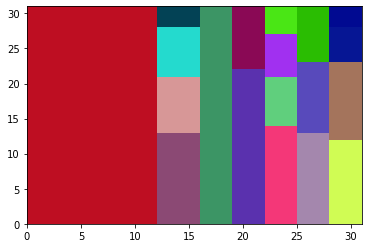


Paper dimensions: 32x32
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=3677
mzn-stat: flatIntVars=1704
mzn-stat: flatBoolConstraints=2111
mzn-stat: flatIntConstraints=5129
mzn-stat: evaluatedReifiedConstraints=185
mzn-stat: evaluatedHalfReifiedConstraints=4748
mzn-stat: eliminatedImplications=1424
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.492207
mzn-stat-end
mzn-stat: initTime=0.054
mzn-stat: solveTime=0.065
mzn-stat: solutions=1
mzn-stat: variables=5381
mzn-stat: propagators=7100
mzn-stat: propagations=141957
mzn-stat: nodes=2163
mzn-stat: failures=1075
mzn-stat: restarts=0
mzn-stat: peakDepth=90
mzn-stat-end
Solution: [[23, 29], [26, 28], [8,

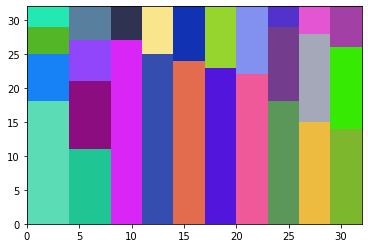


Paper dimensions: 33x33
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2204
mzn-stat: flatIntVars=902
mzn-stat: flatBoolConstraints=1127
mzn-stat: flatIntConstraints=2936
mzn-stat: evaluatedReifiedConstraints=118
mzn-stat: evaluatedHalfReifiedConstraints=2659
mzn-stat: eliminatedImplications=672
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.290618
mzn-stat-end
mzn-stat: initTime=0.07
mzn-stat: solveTime=0.038
mzn-stat: solutions=1
mzn-stat: variables=3117
mzn-stat: propagators=3811
mzn-stat: propagations=85154
mzn-stat: nodes=1544
mzn-stat: failures=766
mzn-stat: restarts=0
mzn-stat: peakDepth=67
mzn-stat-end
Solution: [[18, 30], [24, 29], [24, 24], [30, 27], [24, 17], [27, 25], [2

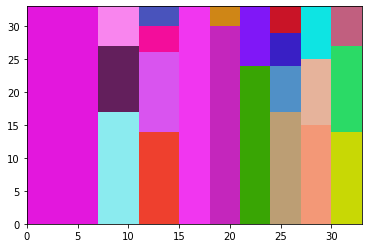


Paper dimensions: 34x34
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1989
mzn-stat: flatIntVars=909
mzn-stat: flatBoolConstraints=1106
mzn-stat: flatIntConstraints=2739
mzn-stat: evaluatedReifiedConstraints=106
mzn-stat: evaluatedHalfReifiedConstraints=2512
mzn-stat: eliminatedImplications=720
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.29724
mzn-stat-end
mzn-stat: initTime=0.067
mzn-stat: solveTime=0.014
mzn-stat: solutions=1
mzn-stat: variables=2941
mzn-stat: propagators=3481
mzn-stat: propagations=38585
mzn-stat: nodes=715
mzn-stat: failures=353
mzn-stat: restarts=0
mzn-stat: peakDepth=26
mzn-stat-end
Solution: [[25, 31], [31, 30], [22, 29], [31, 24], [22, 22], [28, 26], [19, 25], [25, 21],

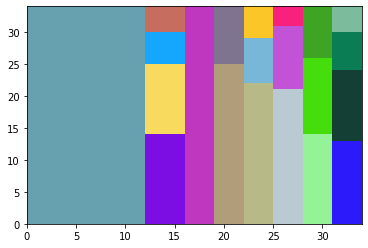


Paper dimensions: 35x35
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1550
mzn-stat: flatIntVars=521
mzn-stat: flatBoolConstraints=657
mzn-stat: flatIntConstraints=1942
mzn-stat: evaluatedReifiedConstraints=78
mzn-stat: evaluatedHalfReifiedConstraints=1709
mzn-stat: eliminatedImplications=300
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.224851
mzn-stat-end
mzn-stat: initTime=0.051
mzn-stat: solveTime=0.053
mzn-stat: solutions=1
mzn-stat: variables=2079
mzn-stat: propagators=2430
mzn-stat: propagations=107672
mzn-stat: nodes=2579
mzn-stat: failures=1283
mzn-stat: restarts=0
mzn-stat: peakDepth=61
mzn-stat-end
Solution: [[32, 32], [32, 28], [26, 30], [32, 22], [29, 28], [26, 22], [29, 19], [3

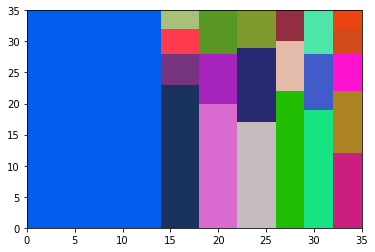


Paper dimensions: 36x36
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1785
mzn-stat: flatIntVars=718
mzn-stat: flatBoolConstraints=895
mzn-stat: flatIntConstraints=2356
mzn-stat: evaluatedReifiedConstraints=85
mzn-stat: evaluatedHalfReifiedConstraints=2154
mzn-stat: eliminatedImplications=525
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.273708
mzn-stat-end
mzn-stat: initTime=0.059
mzn-stat: solveTime=0.028
mzn-stat: solutions=1
mzn-stat: variables=2570
mzn-stat: propagators=2782
mzn-stat: propagations=72102
mzn-stat: nodes=1837
mzn-stat: failures=913
mzn-stat: restarts=0
mzn-stat: peakDepth=51
mzn-stat-end
Solution: [[33, 33], [24, 32], [27, 31], [27, 25], [33, 26], [24, 24], [2

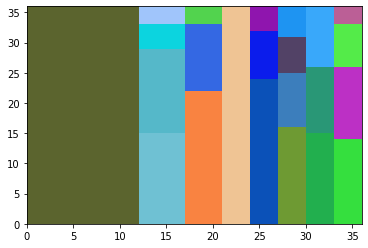


Paper dimensions: 37x37
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2111
mzn-stat: flatIntVars=652
mzn-stat: flatBoolConstraints=882
mzn-stat: flatIntConstraints=2607
mzn-stat: evaluatedReifiedConstraints=85
mzn-stat: evaluatedHalfReifiedConstraints=2362
mzn-stat: eliminatedImplications=406
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.288526
mzn-stat-end
mzn-stat: initTime=0.067
mzn-stat: solveTime=0.054
mzn-stat: solutions=1
mzn-stat: variables=2811
mzn-stat: propagators=3014
mzn-stat: propagations=121953
mzn-stat: nodes=2065
mzn-stat: failures=1027
mzn-stat: restarts=0
mzn-stat: peakDepth=54
mzn-stat-end
Solution: [[31, 34], [34, 33], [31, 29]

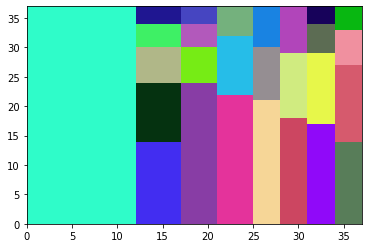


Paper dimensions: 38x38
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1022
mzn-stat: flatIntVars=335
mzn-stat: flatBoolConstraints=389
mzn-stat: flatIntConstraints=1266
mzn-stat: evaluatedReifiedConstraints=50
mzn-stat: evaluatedHalfReifiedConstraints=1082
mzn-stat: eliminatedImplications=146
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.18681
mzn-stat-end
mzn-stat: initTime=0.041
mzn-stat: solveTime=0.034
mzn-stat: solutions=1
mzn-stat: variables=1365
mzn-stat: propagators=1527
mzn-stat: propagations=97388
mzn-stat: nodes=2286
mzn-stat: failures=1137
mzn-stat: restarts=0
mzn-stat: peakDepth=69
mzn-stat-end
Solution: [[32, 35], [35, 34], [35, 29], [32, 29], [32, 22], [35, 21], [32, 13], [35, 11], [35, 0], [32, 0], [

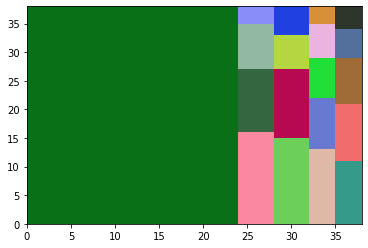


Paper dimensions: 39x39
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2157
mzn-stat: flatIntVars=525
mzn-stat: flatBoolConstraints=752
mzn-stat: flatIntConstraints=2540
mzn-stat: evaluatedReifiedConstraints=78
mzn-stat: evaluatedHalfReifiedConstraints=2257
mzn-stat: eliminatedImplications=234
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.244909
mzn-stat-end
mzn-stat: initTime=0.065
mzn-stat: solveTime=0.182
mzn-stat: solutions=1
mzn-stat: variables=2690
mzn-stat: propagators=3094
mzn-stat: propagations=352826
mzn-stat: nodes=5709
mzn-stat: failures=2846
mzn-stat: restarts=0
mzn-stat: peakDepth=118
mzn-stat-end
Solution: [[33, 36], [36

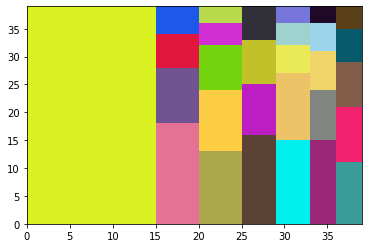


Paper dimensions: 40x40
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=931
mzn-stat: flatIntVars=320
mzn-stat: flatBoolConstraints=382
mzn-stat: flatIntConstraints=1154
mzn-stat: evaluatedReifiedConstraints=41
mzn-stat: evaluatedHalfReifiedConstraints=1024
mzn-stat: eliminatedImplications=165
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.19346
mzn-stat-end
mzn-stat: initTime=0.035
mzn-stat: solveTime=0.007
mzn-stat: solutions=1
mzn-stat: variables=1326
mzn-stat: propagators=1182
mzn-stat: propagations=25254
mzn-stat: nodes=596
mzn-stat: failures=294
mzn-stat: restarts=0
mzn-stat: peakDepth=37
mzn-stat-end
Solution: [[34, 37], [37, 36], [34, 32], [37, 30], [34, 25], [37, 22], [34, 16], [37, 12], [37, 0], [34,

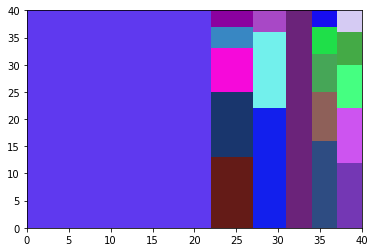


Instance size / Running time plot:


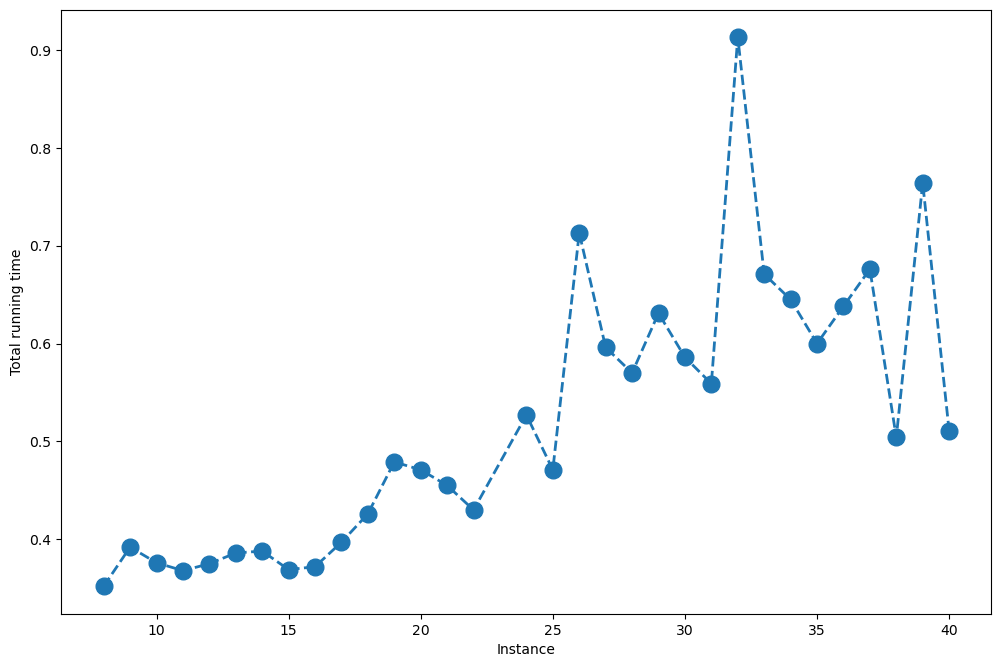

In [113]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    current_instance = f"{i}x{i}"
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    bl_corners = []
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    solutions = %minizinc -s pwp-v6
    end_time = time()
    if solutions:
        show_solutions(w_paper, h_paper, n, presents, solutions, model='cp')
        instances.append(i)
        times.append(end_time - start_time)
    print()

if len(instances) > 1:
    print("Instance size / Running time plot:")
    show_running_times(instances, times)

### First model 

In this first CP model we tried to put a single constraint, regarding rectangles overlapment. The constraint is implemented as a list of disjunctive comparisons and, because of that, running times of the whole model tend to be very high, starting from the smaller and easier instances.

In [88]:
%%mzn_model pwp-v1
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;

% Variables
array[1..n, 1..2] of var 0..max(w_paper, h_paper) - 1: bl_corners;

% Constraints
% Presents cannot overlap
constraint forall(i, j in 1..n where j > i) (
    max(bl_corners[i, 1], bl_corners[j, 1]) >= min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) \/
    max(bl_corners[i, 2], bl_corners[j, 2]) >= min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2])
);

% Reduce presents domains
constraint forall(i in 1..n) (bl_corners[i, 1] <= w_paper - presents[i, 1]);
constraint forall(i in 1..n) (bl_corners[i, 2] <= h_paper - presents[i, 2]);

% Search
solve satisfy;

### Second model

In this second CP model we refactored the non-overlapping constraint by removing the disjuctive part and instead forcing all overlapping areas to be zero. Moreover, we introduced a new list of variables (`bl_corners_values`) which can be viewed as a linearization of the 2D coordinates associated with rectangles bottom left corners, since we wanted to add redundant constraints, to deal with values distribution inside the 2D space. In particular, we posed an `alldifferent` constraint over `bl_corners_values` and we forced a single rectangle to be located at `(0, 0)`.

In [93]:
%%mzn_model pwp-v2
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

% Variables
array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function var int: x_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) - max(bl_corners[i, 1], bl_corners[j, 1]));
function var int: y_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2]) - max(bl_corners[i, 2], bl_corners[j, 2]));
function var int: overlap_area(int: i, int: j) = x_overlap(i, j) * y_overlap(i, j);

% Channeling constraints
predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint forall(i, j in 1..n where j > i) (overlap_area(i, j) == 0);

% Reduce presents domains
constraint forall(i in 1..n) (bl_corners[i, 1] <= w_paper - presents[i, 1]);
constraint forall(i in 1..n) (bl_corners[i, 2] <= h_paper - presents[i, 2]);

% Search
solve satisfy;

### Third model

In this third model we tried to further reduce our variable's domains, by introducing a new list of variables (`tr_corners`), representing top right corners of each rectangle. The main achievement of this model is the introduction of the global constraint `diffn_k` to handle non-overlapment and of the global constrainst `cumulative` to maximally stack rectangles on each axis. Moreover, we used top right corners to force rectangles to stay inside the outer container.

In [97]:
%%mzn_model pwp-v3
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of 1..max_dim: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);
array[1..n] of 1..max_dim: presents_xs = [presents[i, 1] | i in 1..n];
array[1..n] of 1..max_dim: presents_ys = [presents[i, 2] | i in 1..n];

% Variables
array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n, 1..2] of var 1..max_dim: tr_corners;
array[1..n] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[1..n] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[1..n] of var 0..h_paper - min_present_dim: bl_corners_ys;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Search
solve satisfy;

### Fourth model

In this fourth model we tried to add different constraints, to possibly enhance running times:
* Redundant constraints:
    * Try and stack two presents having the same width s.t. their heights would sum to the total height 
    * Sum of all the areas of all the placed presents equal to total area
* Symmetry breaking constraints:
    * Presents in the same column ordered by width (which resulted in an overall slowdown)
    * Biggest rectangle contained in the lower-left quadrant (which didn't lead to any major improvement)

In [127]:
%%mzn_model pwp-v4
include "globals.mzn";

%Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Two presents sum to total height or width
constraint forall(i, j in ns where j > i) (
    presents_xs[i] == presents_xs[j] /\ presents_ys[i] + presents_ys[j] == h_paper -> 
    bl_corners_ys[j] = presents_ys[i] /\ bl_corners_ys[i] = 0
);
constraint forall(i, j in ns where j > i) (
    presents_ys[i] == presents_ys[j] /\ presents_xs[i] + presents_xs[j] == w_paper -> 
    bl_corners_xs[j] = presents_xs[i] /\ bl_corners_xs[i] = 0
);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Symmetry breaking constraints
% Biggest rectangle contained in the lower-left quadrant
constraint 
    bl_corners_xs[max_present_ind] <= (w_paper - presents_xs[max_present_ind]) / 2 /\ 
    bl_corners_ys[max_present_ind] <= (h_paper - presents_ys[max_present_ind]) / 2;

/*
% Presents in the same column ordered by width
constraint forall(i, j in ns where j > i) (
    bl_corners_xs[i] == bl_corners_xs[j] /\ presents_xs[i] <= presents_xs[j] -> 
    bl_corners_ys[i] > bl_corners_ys[j]
);
*/

% Search
solve satisfy;

### Fifth model

In this fifth model we are generalizing the idea of stacking two rectangles of the same width with heights summing to the total height, to:
* Partition rectangles in groups representing different widths (`presents_group_xs`)
* Check whether all groups form one or more columns (predicate `is_col_stacking_feasible`)
    * If possible, assign each rectangle to a specific column and constrain the other rectangles to follow (predicate `stack_cols`)
    * If not possible, operate like in previous models

The predicate `stack_cols` works as follows:
* For each rectangle group
    * Find a feasible `bin_packing` over a pre-computed number of columns
    * For each rectangle in the same column (same bin), add a constraint to fix its bottom left corner

We also tried to combine our ad-hoc column stacking procedure with the approaches described below (_intervals_ and _anchor points_), without any luck.

In [98]:
%%mzn_model pwp-v5
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[int] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[indexes[h]] == sum([weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("Column stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Symmetry breaking constraints
% Biggest rectangle contained in the lower-left quadrant
constraint not(col_stacking_feasible) ->
    bl_corners_xs[max_present_ind] <= (w_paper - presents_xs[max_present_ind]) / 2 /\ 
    bl_corners_ys[max_present_ind] <= (h_paper - presents_ys[max_present_ind]) / 2;

% Search
solve satisfy;

#### Intervals approach

The following section contains a block of code that was tested in the above model, but didn't provide significant improvements. It represents an idea taken from the paper _New Improvements in Optimal Rectangle Packing (Eric Huang, Richard E. Korf)_, where domains associated with the x-coordinate of bottom left corners are reduced on the basis of a variable-sized interval:
> \[...\] a rectangle is assigned an interval of x-coordinates. Interval sizes are hand-picked for each rectangle prior to search, and they induce a smaller rectangle representing the common intersecting area of placing the rectangle in any location in the interval. \[...\] we assign all x-coordinates prior to any y-coordinates, and use interval variables for the x-coordinates. We set a rectangle’s interval size to 0.35 times its width, which gave us the best performance. Finally, we do not use interval variables for the y-coordinates.`

In [ ]:
% Constants
array[ns] of int: x_intervals_sizes = [ceil(presents_xs[i] * 0.35) | i in ns];

% Variables
array[ns, 1..2] of var 0..w_paper: x_intervals;

% Channeling constraints
predicate x_intervals_channeling(int: i) = 
    x_intervals[i, 2] == x_intervals[i, 1] + x_intervals_sizes[i] /\
    bl_corners_xs[i] >= x_intervals[i, 1] /\
    bl_corners_xs[i] <= x_intervals[i, 2];
constraint forall(i in ns) (x_intervals_channeling(i));

% Constraints
% Reduce corners domains based on x intervals
constraint forall(i, j in ns where j != i) (
    not(
        bl_corners_xs[j] < x_intervals[i, 2] + presents_xs[i] - x_intervals_sizes[i] /\ 
        bl_corners_xs[j] > x_intervals[i, 2] /\
        bl_corners_ys[j] >= bl_corners_ys[i] /\
        bl_corners_ys[j] < bl_corners_ys[i] + presents_ys[i]     
    )
);

% Search
solve :: seq_search([
    int_search(x_intervals, smallest, indomain_min),
    int_search(bl_corners_xs, smallest, indomain_min),
    int_search(bl_corners_ys, smallest, indomain_min)
]) satisfy;

#### Anchor points approach

The following section contains a block of code that was tested in the above model, but didn't provide significant improvements. It represents a reduction on each present's domain, s.t. bottom left corners reside on corners of other rectangles or on the wrapping paper borders.

The main problem of this implementation was our inability of correctly expressing the constraint in an efficient way.

In [ ]:
% Variables
array[ns, 1..4] of var 0..coord_to_value(w_paper, h_paper): corners_values;

% Channeling constraints
predicate corners_values_channeling(int: i) = 
    corners_values[i, 1] == bl_corners_values[i] /\ 
    corners_values[i, 2] == coord_to_value(bl_corners_xs[i] + presents_xs[i], bl_corners_ys[i]) /\
    corners_values[i, 3] == coord_to_value(tr_corners[i, 1], tr_corners[i, 2]) /\
    corners_values[i, 4] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i] + presents_ys[i]);
constraint forall(i in ns) (corners_values_channeling(i));

% Constraints
% Corners anchor points
predicate anchor_points() = let {
        array[1..n * 4] of var int: lin_corners_values = array1d(1..n * 4, corners_values)
    } in
    nvalue(lin_corners_values) <= 2 * n + 2 /\ 
    count_eq(lin_corners_values, coord_to_value(0, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(0, w_paper), 1) /\
    count_eq(lin_corners_values, coord_to_value(h_paper, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(w_paper, h_paper), 1);
constraint anchor_points();

### Sixth model

In this sixth final model we are keeping the column stacking mechanism and introducing a new variables ordering (by decreasing rectangles areas) for symmetry breaking constraints and for a new search strategy. 

These adaptations were taken from _Implementation and Evaluation of a Sweep-Based Propagator for Diffn in Gecode (Mikael Östlund)_.

Moreover, we tried to implement another anchor points approach, which didn't work out as expected.

In [103]:
%%mzn_model pwp-v6
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[ns] of ns: order = sort_by(ns, [-areas[i] | i in ns]);
array[1..card(presents_xs_values)] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    array[1..n_presents] of 1..n_presents: positions = sort_by([j | j in 1..n_presents], [-weights[j] | j in 1..n_presents]);
    array[1..n_presents] of ns: ord_indexes = [indexes[j] | j in positions];
    array[1..n_presents] of 1..h_paper: ord_weights = [weights[j] | j in positions];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, ord_weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[ord_indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[ord_indexes[h]] == sum([ord_weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("Column stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% Non-optimal constraints
% Anchor points
/*
constraint forall(i in ns)(
    member([0] ++ [bl_corners_xs[j] + presents_xs[j] | j in ns where j != i], bl_corners_xs[i]) /\
    member([0] ++ [bl_corners_ys[j] + presents_ys[j] | j in ns where j != i], bl_corners_ys[i])
);
*/

% Symmetry breaking constraints
% The biggest rectangle should be placed below the second biggest
constraint let {
    int: i = order[1], int: j = order[2]
} in not(col_stacking_feasible) ->
    lex_less([bl_corners_ys[i], bl_corners_xs[i]], [bl_corners_ys[j], bl_corners_xs[j]]);

% Search
solve::
    if not(col_stacking_feasible) then
        seq_search([
            int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
            int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
        ])
    else int_search(bl_corners_values, dom_w_deg, indomain_min, complete)
    endif
satisfy;

### Seventh model (with rotation and same dimensions handling)

This model is dedicated to the implementation of the optional parts of the project, namely rotation and same dimensions handling.
About rotation, we removed the column stacking approach since presents dimensions are now considered as variables, and we introduced the global constraint `geost_bb` which can be used to find appropriate positions and rotations of the given rectangles without overlaps, by constraining them to be contained in a given bounding box. This approach obviously turned out to be much slower w.r.t. our sixth model. To get better results, we could try to find the minimum number of rotations needed to make column stacking feasible and proceed like before.
About rectangles with same dimensions, we simply included a symmetry breaking constraint accounting for pairwise positioning of equally-sized rectangles.

In [69]:
%%mzn_model pwp-v7
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
int: k = 2;
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
set of int: dim = 1..k;
set of int: ns = 1..n;
set of int: ns_rot = 1..2 * n;
array[dim] of int: l = [0, 0];
array[dim] of int: u = [w_paper, h_paper];
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[ns] of ns: order = sort_by(ns, [-areas[i] | i in ns]);
array[ns_rot, dim] of int: rect_size = array2d(ns_rot, dim, [get_rot(i, j, k)| i in ns, j, k in 0..1]);
array[ns_rot, dim] of int: rect_offset = array2d(ns_rot, dim, [0 | i in 1..4 * n]);
array[ns_rot] of set of ns_rot: shape = [{i}| i in ns_rot];
array[ns] of set of ns_rot: valid_shapes = [{i, i + 1}| i in ns_rot where i mod 2 != 0];

% Variables
array[ns, dim] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_dim: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var min_present_dim..max_present_dim: actual_presents_xs = [actual_dim(i, 1) | i in ns];
array[ns] of var min_present_dim..max_present_dim: actual_presents_ys = [actual_dim(i, 2) | i in ns];
array[ns] of var ns_rot: kind;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function int: other_axis(int: axis) = if axis == 1 then 2 elseif axis == 2 then 1 else -1 endif;
function int: get_dim(int: ind, int: axis) = if axis == 0 then presents_xs[ind] elseif axis == 1 then presents_ys[ind] else -1 endif;
function int: get_rot(int: ind, int: axis, int: rot) = if rot == 0 then get_dim(ind, axis) elseif rot == 1 then get_dim(ind, 1 - axis) else -1 endif;
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function var int: actual_dim(int: ind, int: axis) = if kind[ind] mod 2 == 0 then presents[ind, other_axis(axis)] else presents[ind, axis] endif;

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + actual_presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + actual_presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% Presents cannot overlap
constraint diffn(bl_corners_xs, bl_corners_ys, actual_presents_xs, actual_presents_ys);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, actual_presents_xs, actual_presents_ys, h_paper);
constraint cumulative(bl_corners_ys, actual_presents_ys, actual_presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - actual_presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - actual_presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= actual_presents_xs[i] /\ 
    tr_corners[i, 2] >= actual_presents_ys[i]
);

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% Rectangles must have valid shapes
constraint forall (obj in ns) (kind[obj] in valid_shapes[obj]);

% Non-overlap, bounding box, rotation handling 
constraint geost_bb(k, rect_size, rect_offset, shape, bl_corners, kind, l, u);

% Symmetry breaking constraints
% The biggest rectangle should be placed below the second biggest
constraint let {
    int: i = order[1], int: j = order[2]
} in lex_less([bl_corners_ys[i], bl_corners_xs[i]], [bl_corners_ys[j], bl_corners_xs[j]]);

% Rectangles with same dimensions handling
constraint forall(i in ns)(
    let {
        array[int] of int: same_dim_ind = [j | j in ns where presents_xs[j] = presents_xs[i] /\ presents_ys[j] = presents_ys[i]]
    } in 
        if length(same_dim_ind) > 1 /\ min(same_dim_ind) = i then
            forall(j in index_set(same_dim_ind) where j > 1) (
                lex_less(
                    [bl_corners_ys[same_dim_ind[j - 1]], bl_corners_xs[same_dim_ind[j - 1]]], 
                    [bl_corners_ys[same_dim_ind[j]], bl_corners_xs[same_dim_ind[j]]]
                )
            )
        else true 
        endif
);

% Search
solve:: seq_search([
    int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
    int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
]) satisfy;

## SMT

### Functions

In [114]:
def member(x, l):
    '''
    Return a contraint computing membership testing
    '''
    return Or([x == l[i] for i in range(len(l))])

def z3_max_list(l):
    '''
    Return a constraint computing the maximum over a list of variables
    '''
    c = []
    max_value = Int(rand_str())
    c.append(member(max_value, l))
    for i in range(len(l)):
        c.append(max_value >= l[i])
    return max_value, c

def z3_max(x, y):
    '''
    Return a constraint computing the maximum of two variables
    '''
    return If(x > y, x, y)

def z3_min_list(l):
    '''
    Return a constraint computing the minimum over a list of variables
    '''
    c = []
    min_value = Int(rand_str())
    c.append(member(min_value, l))
    for i in range(len(l)):
        c.append(min_value <= l[i])
    return min_value, c

def z3_min(x, y):
    '''
    Return a constraint computing the minimum of two variables
    '''
    return If(x < y, x, y)

def z3_bool2int(v):
    '''
    Convert a boolean variable to an integer one
    '''
    return IntSort().cast(v)

def z3_diffn(x, y, dx, dy):
    '''
    Return a list of constraints computing non-overlapping checks
    '''
    c = []
    n = len(x)
    for i in range(n):
        for j in range(i + 1, n):
            c.append(
                And(Or([
                    x[i] + dx[i] <= x[j],
                    y[i] + dy[i] <= y[j],
                    x[j] + dx[j] <= x[i],
                    y[j] + dy[j] <= y[i]
                ]))
            )
    return c

def z3_alldifferent_mat(l, s):
    '''
    Return a list of constraints computing all different checks
    '''
    assert(s > 1)
    
    c = []
    n = len(l)
    for i in range(n):
        for j in range(i + 1, n):
            disjunction = []
            for k in range(s):
                disjunction.append(l[i][k] != l[j][k])
            c.append(Or(disjunction))
    return c

def z3_cumulative(s, d, r, b, ls, us):
    '''
    Return a list of constraints computing cumulative checks.
    Here, resources `r`, durations `d` and bound `b` must be fixed
    '''
    c = []
    early = ls
    late = us + max(d)
    tasks = [i for i in range(len(s)) if r[i] > 0 and d[i] > 0]
    if late - early > 5000:
        for i in tasks:
            c1 = []
            for j in tasks:
                if j != i:
                    c1.append(z3_bool2int(And(s[j] <= s[i], s[i] < s[j] + d[j])) * r[j])
            c.append(b >= r[i] + Sum(c1))
    else:
        for t in range(early, late + 1):
            for i in tasks:
                c.append(
                    Sum([(If(s[i] <= t, 1, 0) * If(t < s[i] + d[i], 1, 0)) * r[i] for i in tasks]) <= b
                )
    return c

### Input

In [160]:
instance = None
min_instance, max_instance = 8, 40

Paper dimensions: 8x8
Presents dimensions: [[3, 3], [3, 5], [5, 3], [5, 5]]
(:added-eqs                 40
 :arith-assert-diseq        22
 :arith-assert-lower        35
 :arith-assert-upper        31
 :arith-bound-prop          53
 :arith-eq-adapter          28
 :arith-fixed-eqs           4
 :arith-num-rows            12
 :arith-offset-eqs          10
 :arith-pivots              2
 :arith-row-summations      4
 :arith-tableau-max-columns 21
 :arith-tableau-max-rows    12
 :binary-propagations       60
 :conflicts                 1
 :decisions                 5
 :del-clause                4
 :final-checks              1
 :max-memory                121.73
 :memory                    71.37
 :mk-bool-var               122
 :mk-clause                 82
 :num-allocs                62218883
 :num-checks                1
 :propagations              83
 :rlimit-count              56796476945.00)
Total running time: 0.041 seconds
Solution: [[5, 0], [0, 3], [0, 0], [3, 3]]


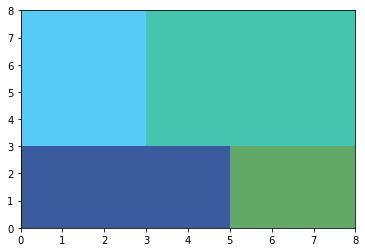


Paper dimensions: 9x9
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]
(:added-eqs                 66
 :arith-assert-diseq        55
 :arith-assert-lower        80
 :arith-assert-upper        67
 :arith-bound-prop          80
 :arith-conflicts           6
 :arith-eq-adapter          39
 :arith-fixed-eqs           3
 :arith-num-rows            20
 :arith-offset-eqs          23
 :arith-pivots              22
 :arith-row-summations      95
 :arith-tableau-max-columns 31
 :arith-tableau-max-rows    20
 :binary-propagations       121
 :conflicts                 7
 :decisions                 19
 :del-clause                16
 :final-checks              1
 :max-memory                121.73
 :memory                    71.38
 :mk-bool-var               173
 :mk-clause                 127
 :num-allocs                62255958
 :num-checks                1
 :propagations              171
 :rlimit-count              56796488213.00)
Total running time: 0.043 seconds
Solution: [[0, 6], 

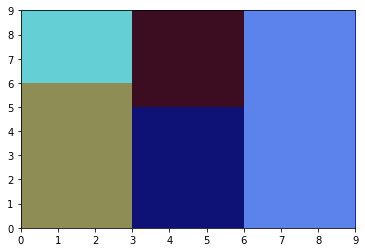


Paper dimensions: 10x10
Presents dimensions: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]
(:added-eqs                 143
 :arith-assert-diseq        109
 :arith-assert-lower        111
 :arith-assert-upper        147
 :arith-bound-prop          176
 :arith-conflicts           9
 :arith-eq-adapter          54
 :arith-fixed-eqs           7
 :arith-num-rows            30
 :arith-offset-eqs          54
 :arith-pivots              17
 :arith-row-summations      90
 :arith-tableau-max-columns 43
 :arith-tableau-max-rows    30
 :binary-propagations       212
 :conflicts                 12
 :decisions                 51
 :del-clause                10
 :final-checks              1
 :max-memory                121.73
 :memory                    71.38
 :minimized-lits            1
 :mk-bool-var               240
 :mk-clause                 247
 :num-allocs                62294660
 :num-checks                1
 :propagations              329
 :rlimit-count              56796503702.00)
Total r

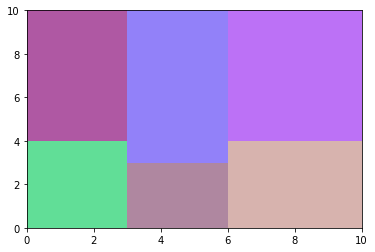


Paper dimensions: 11x11
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]
(:added-eqs                 313
 :arith-assert-diseq        407
 :arith-assert-lower        387
 :arith-assert-upper        534
 :arith-bound-prop          342
 :arith-conflicts           29
 :arith-eq-adapter          70
 :arith-fixed-eqs           19
 :arith-num-rows            42
 :arith-offset-eqs          106
 :arith-pivots              87
 :arith-row-summations      681
 :arith-tableau-max-columns 57
 :arith-tableau-max-rows    42
 :binary-propagations       880
 :conflicts                 38
 :decisions                 232
 :del-clause                4
 :final-checks              1
 :max-memory                121.73
 :memory                    71.39
 :minimized-lits            15
 :mk-bool-var               314
 :mk-clause                 459
 :num-allocs                62335572
 :num-checks                1
 :propagations              1667
 :rlimit-count              567965384

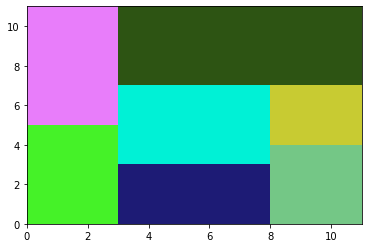


Paper dimensions: 12x12
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]
(:added-eqs                 4171
 :arith-assert-diseq        5325
 :arith-assert-lower        7181
 :arith-assert-upper        6186
 :arith-bound-prop          1600
 :arith-conflicts           306
 :arith-eq-adapter          88
 :arith-fixed-eqs           320
 :arith-num-rows            56
 :arith-offset-eqs          1240
 :arith-pivots              1679
 :arith-row-summations      16260
 :arith-tableau-max-columns 73
 :arith-tableau-max-rows    56
 :binary-propagations       17402
 :conflicts                 551
 :decisions                 1206
 :del-clause                18
 :final-checks              1
 :max-memory                121.73
 :memory                    71.39
 :minimized-lits            800
 :mk-bool-var               398
 :mk-clause                 2253
 :num-allocs                62379849
 :num-checks                1
 :propagations              39560
 :restart

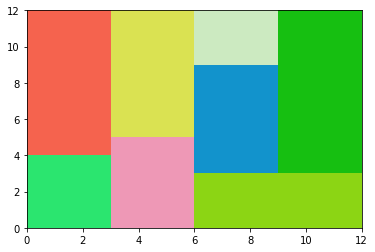


Paper dimensions: 13x13
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]
(:added-eqs                 4439
 :arith-assert-diseq        6796
 :arith-assert-lower        8382
 :arith-assert-upper        7876
 :arith-bound-prop          2052
 :arith-conflicts           321
 :arith-eq-adapter          108
 :arith-fixed-eqs           260
 :arith-num-rows            72
 :arith-offset-eqs          1583
 :arith-pivots              1845
 :arith-row-summations      20888
 :arith-tableau-max-columns 91
 :arith-tableau-max-rows    72
 :binary-propagations       19885
 :conflicts                 617
 :decisions                 1586
 :del-clause                6
 :final-checks              1
 :max-memory                121.73
 :memory                    71.39
 :minimized-lits            1311
 :mk-bool-var               492
 :mk-clause                 2797
 :num-allocs                62426959
 :num-checks                1
 :propagations              48418


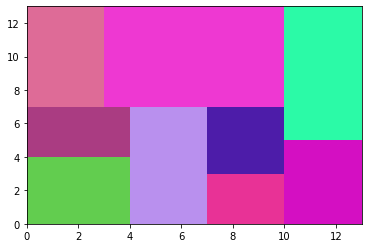


Paper dimensions: 14x14
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]
(:added-eqs                 7404
 :arith-assert-diseq        8274
 :arith-assert-lower        10732
 :arith-assert-upper        10414
 :arith-bound-prop          2116
 :arith-conflicts           363
 :arith-eq-adapter          108
 :arith-fixed-eqs           647
 :arith-num-rows            72
 :arith-offset-eqs          2387
 :arith-pivots              2124
 :arith-row-summations      24182
 :arith-tableau-max-columns 91
 :arith-tableau-max-rows    72
 :binary-propagations       26661
 :conflicts                 776
 :decisions                 1820
 :del-clause                18
 :final-checks              1
 :max-memory                121.73
 :memory                    71.40
 :minimized-lits            1548
 :mk-bool-var               492
 :mk-clause                 3020
 :num-allocs                62474163
 :num-checks                1
 :propagations              67

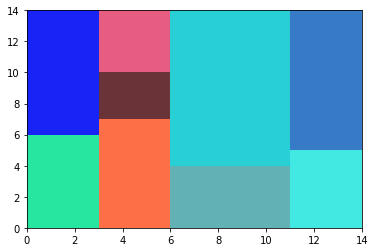


Paper dimensions: 15x15
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]
(:added-eqs                 1703
 :arith-assert-diseq        2502
 :arith-assert-lower        3020
 :arith-assert-upper        3275
 :arith-bound-prop          1212
 :arith-conflicts           189
 :arith-eq-adapter          129
 :arith-fixed-eqs           94
 :arith-num-rows            90
 :arith-offset-eqs          600
 :arith-pivots              797
 :arith-row-summations      11724
 :arith-tableau-max-columns 111
 :arith-tableau-max-rows    90
 :binary-propagations       6417
 :conflicts                 230
 :decisions                 1099
 :del-clause                43
 :final-checks              1
 :max-memory                121.73
 :memory                    71.42
 :minimized-lits            104
 :mk-bool-var               593
 :mk-clause                 1597
 :num-allocs                62523090
 :num-checks                1
 :propagations             

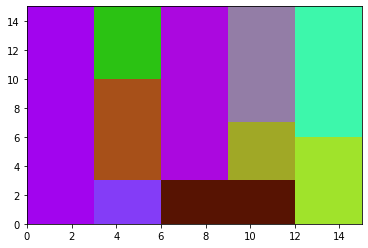


Paper dimensions: 16x16
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]
(:added-eqs                 13973
 :arith-assert-diseq        18616
 :arith-assert-lower        25029
 :arith-assert-upper        22075
 :arith-bound-prop          4022
 :arith-conflicts           1031
 :arith-eq-adapter          130
 :arith-fixed-eqs           962
 :arith-num-rows            90
 :arith-offset-eqs          5054
 :arith-pivots              6221
 :arith-row-summations      86840
 :arith-tableau-max-columns 111
 :arith-tableau-max-rows    90
 :binary-propagations       52407
 :conflicts                 1655
 :decisions                 4076
 :del-clause                24
 :final-checks              1
 :max-memory                121.73
 :memory                    71.42
 :minimized-lits            2777
 :mk-bool-var               596
 :mk-clause                 5834
 :num-allocs                62574303
 :num-checks                1
 :propagations  

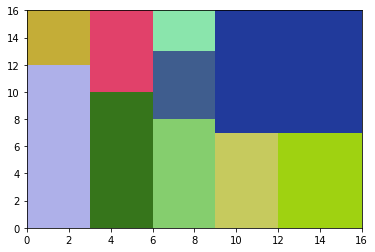


Paper dimensions: 17x17
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]
(:added-eqs                 7922
 :arith-assert-diseq        10239
 :arith-assert-lower        13036
 :arith-assert-upper        12419
 :arith-bound-prop          3852
 :arith-conflicts           491
 :arith-eq-adapter          180
 :arith-fixed-eqs           665
 :arith-num-rows            132
 :arith-offset-eqs          3156
 :arith-pivots              2476
 :arith-row-summations      43304
 :arith-tableau-max-columns 157
 :arith-tableau-max-rows    132
 :binary-propagations       23833
 :conflicts                 611
 :decisions                 3362
 :del-clause                16
 :final-checks              1
 :max-memory                121.73
 :memory                    71.42
 :minimized-lits            677
 :mk-bool-var               834
 :mk-clause                 4687
 :num-allocs                62631595
 :num-checks                1
 :p

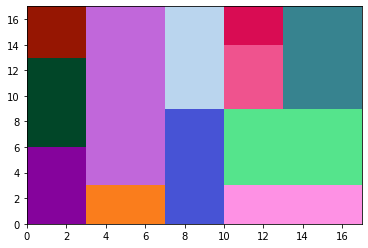


Paper dimensions: 18x18
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]
(:added-eqs                 1067097
 :arith-assert-diseq        2545856
 :arith-assert-lower        3661604
 :arith-assert-upper        3563049
 :arith-bound-prop          253674
 :arith-conflicts           60842
 :arith-eq-adapter          912
 :arith-fixed-eqs           64645
 :arith-num-rows            720
 :arith-offset-eqs          397087
 :arith-pivots              588451
 :arith-row-summations      15161028
 :arith-tableau-max-columns 819
 :arith-tableau-max-rows    720
 :binary-propagations       7820496
 :conflicts                 177918
 :dd-assertions             169126
 :dd-propagations           1955392
 :decisions                 425246
 :del-clause                123933
 :final-checks              1
 :max-memory                121.73
 :memory                    71.48
 :minimized-lits            75

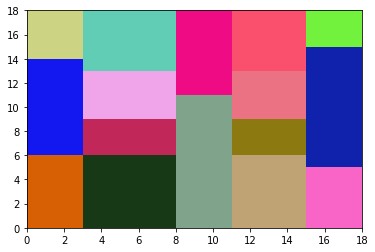


Paper dimensions: 19x19
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]
(:added-eqs                 32721
 :arith-assert-diseq        56350
 :arith-assert-lower        72331
 :arith-assert-upper        64653
 :arith-bound-prop          10806
 :arith-conflicts           2149
 :arith-eq-adapter          237
 :arith-fixed-eqs           1964
 :arith-num-rows            182
 :arith-offset-eqs          13937
 :arith-pivots              12731
 :arith-row-summations      291680
 :arith-tableau-max-columns 211
 :arith-tableau-max-rows    182
 :binary-propagations       146562
 :conflicts                 3370
 :decisions                 14318
 :del-clause                55
 :final-checks              1
 :max-memory                121.73
 :memory                    71.42
 :minimized-lits            4260
 :mk-bool-var               1109
 :mk-clause                 14477
 :num-allocs                62872847
 

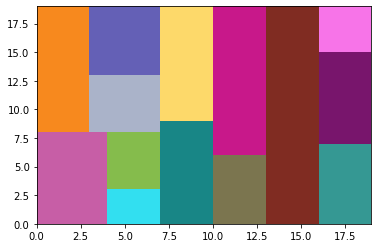


Paper dimensions: 20x20
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]
(:added-eqs                 20685
 :arith-assert-diseq        41781
 :arith-assert-lower        54695
 :arith-assert-upper        49654
 :arith-bound-prop          9205
 :arith-conflicts           2136
 :arith-eq-adapter          238
 :arith-fixed-eqs           1150
 :arith-num-rows            182
 :arith-offset-eqs          7987
 :arith-pivots              12252
 :arith-row-summations      290356
 :arith-tableau-max-columns 211
 :arith-tableau-max-rows    182
 :binary-propagations       115948
 :conflicts                 3315
 :decisions                 13482
 :del-clause                48
 :final-checks              1
 :max-memory                121.73
 :memory                    71.42
 :minimized-lits            3784
 :mk-bool-var               1112
 :mk-clause                 12823
 :num-allocs                62940922
 :

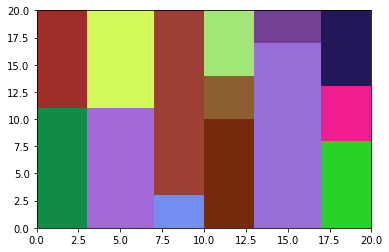


Paper dimensions: 21x21
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]
(:added-eqs                 126280
 :arith-assert-diseq        234871
 :arith-assert-lower        312866
 :arith-assert-upper        286203
 :arith-bound-prop          27574
 :arith-conflicts           8885
 :arith-eq-adapter          270
 :arith-fixed-eqs           8258
 :arith-num-rows            210
 :arith-offset-eqs          49042
 :arith-pivots              63345
 :arith-row-summations      1625668
 :arith-tableau-max-columns 241
 :arith-tableau-max-rows    210
 :binary-propagations       693516
 :conflicts                 15888
 :decisions                 48490
 :del-clause                4191
 :final-checks              1
 :max-memory                121.73
 :memory                    71.47
 :minimized-lits            33071
 :mk-bool-var               1266
 :mk-clause                 43809
 :num-allocs        

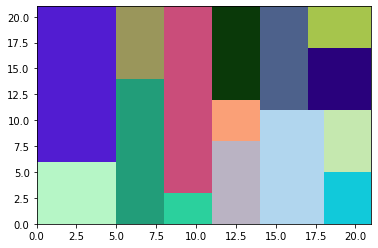


Paper dimensions: 22x22
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]
(:added-eqs                 68819
 :arith-assert-diseq        146923
 :arith-assert-lower        191420
 :arith-assert-upper        175127
 :arith-bound-prop          22965
 :arith-conflicts           5514
 :arith-eq-adapter          303
 :arith-fixed-eqs           5646
 :arith-num-rows            240
 :arith-offset-eqs          27644
 :arith-pivots              35102
 :arith-row-summations      1006758
 :arith-tableau-max-columns 273
 :arith-tableau-max-rows    240
 :binary-propagations       394323
 :conflicts                 8609
 :decisions                 37012
 :del-clause                1173
 :final-checks              1
 :max-memory                121.73
 :memory                    71.47
 :minimized-lits            13326
 :mk-bool-var               1427
 :mk-clause                 31966
 :num-allocs

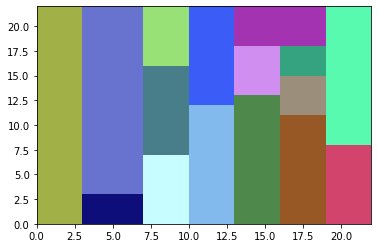


Paper dimensions: 23x23
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]
(:added-eqs                 1008081
 :arith-assert-diseq        2274074
 :arith-assert-lower        3476238
 :arith-assert-upper        3176769
 :arith-bound-prop          244838
 :arith-conflicts           60170
 :arith-eq-adapter          1254
 :arith-fixed-eqs           56245
 :arith-num-rows            1026
 :arith-offset-eqs          421994
 :arith-pivots              505066
 :arith-row-summations      17921205
 :arith-tableau-max-columns 1143
 :arith-tableau-max-rows    1026
 :binary-propagations       5933433
 :conflicts                 113961
 :decisions                 397816
 :del-clause                61804
 :final-checks              1
 :max-memory                121.73
 :memory                    71.49
 :minimized-lits            276393
 :mk-bool-var               5936


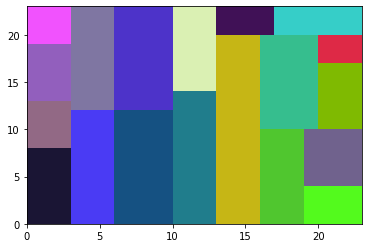


Paper dimensions: 24x24
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]
(:added-eqs                 358379
 :arith-assert-diseq        751197
 :arith-assert-lower        1105273
 :arith-assert-upper        989645
 :arith-bound-prop          93891
 :arith-conflicts           21997
 :arith-eq-adapter          754
 :arith-fixed-eqs           22399
 :arith-num-rows            612
 :arith-offset-eqs          156461
 :arith-pivots              165553
 :arith-row-summations      5536380
 :arith-tableau-max-columns 686
 :arith-tableau-max-rows    612
 :binary-propagations       1895491
 :conflicts                 35167
 :decisions                 140668
 :del-clause                10902
 :final-checks              1
 :max-memory                121.73
 :memory                    71.48
 :minimized-lits            66734
 :mk-bool-var               3565
 :mk-clause         

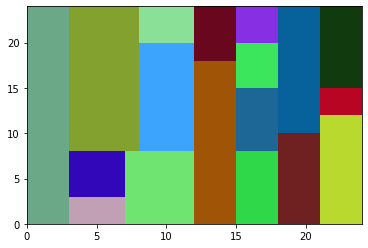


Paper dimensions: 25x25
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]
(:added-eqs                 137948
 :arith-assert-diseq        340339
 :arith-assert-lower        441833
 :arith-assert-upper        409539
 :arith-bound-prop          43117
 :arith-conflicts           10699
 :arith-eq-adapter          417
 :arith-fixed-eqs           9161
 :arith-num-rows            342
 :arith-offset-eqs          60998
 :arith-pivots              71918
 :arith-row-summations      2674928
 :arith-tableau-max-columns 381
 :arith-tableau-max-rows    342
 :binary-propagations       905973
 :conflicts                 16319
 :decisions                 80994
 :del-clause                9434
 :final-checks              1
 :max-memory                121.73
 :memory                    71.48
 :minimized-lits            25146
 :mk-bool-var               1979
 :mk-clause      

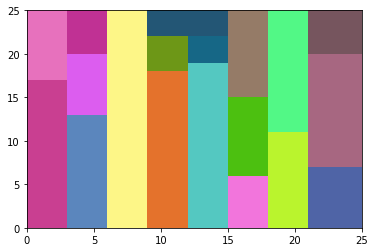


Paper dimensions: 26x26
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]
(:added-eqs                 977827
 :arith-assert-diseq        2545056
 :arith-assert-lower        3821761
 :arith-assert-upper        3579900
 :arith-bound-prop          298004
 :arith-conflicts           60427
 :arith-eq-adapter          1650
 :arith-fixed-eqs           55919
 :arith-num-rows            1386
 :arith-offset-eqs          421620
 :arith-pivots              517067
 :arith-row-summations      22758532
 :arith-tableau-max-columns 1521
 :arith-tableau-max-rows    1386
 :binary-propagations       6863662
 :conflicts                 133400
 :dd-assertions             308971
 :dd-propagations           4126677
 :decisions                 512900
 :del-clause                78498
 :final-checks              1
 :max-memory                121.73
 :memo

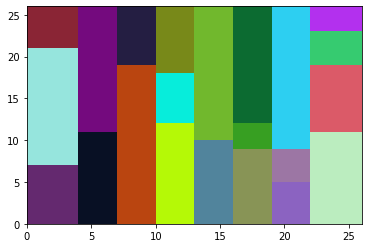


Paper dimensions: 27x27
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]


Z3Exception: model is not available

In [161]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    current_instance = f"{i}x{i}"
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    print(f"Paper dimensions: {current_instance}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    bl_corners, model = smt_v1(w_paper, h_paper, n, presents)
    model.check()
    end_time = time()
    total_time = end_time - start_time
    assignment = model.model()
    bl_corners = [[assignment[bl_corners[i][0]].as_long(), assignment[bl_corners[i][1]].as_long()] for i in range(n)]
    print(model.statistics())
    print(f"Total running time: {round(total_time, 3)} seconds")
    if bl_corners:
        solution = {'bl_corners': bl_corners}
        show_solutions(w_paper, h_paper, n, presents, solution, model='smt')
        instances.append(i)
        times.append(total_time)
    print()
    
if len(instances) > 1:        
    print("Instance size / Running time plot:")
    show_running_times(instances, times)

### First model

In this first SMT model we tried to re-implement the same ideas as in the CP models above, converting code from MiniZinc to be compatible with Z3 specifications. 

In particular, the following constraints turned out to be useful:
* The `diffn` global constraint is used to ensure rectangles non-overlapment
* Constraints for domain reductions, such as top right corners and the existence of a fixed positioning of exactly one rectangle at the origin (for bottom left corners) and one at the wrapping paper border (for top right corners)
* Constraints to ensure that the total occupied area is equal to all the available wrapping paper surface
* The `alldifferent` global constraint was added to check that every bottom left corner is different w.r.t. all the others

Instead, the following constraints were removed from the model, since they resulted in an overall slowdown:
* The `cumulative` global constraint was added for both the x and y axis
* Constraints to check that the actual occupied area of each rectangle is equal to its size
* A symmetry breaking constraint was added to check that the rectangle with the biggest area should be placed to the left and below the second biggest rectangle

In [158]:
def smt_v1(w_paper, h_paper, n, presents):
    # Constants
    # _, sorted_indices = order_presents(presents, method='area', reverse=True)
    presents_xs = [presents[i][0] for i in range(n)]
    presents_ys = [presents[i][1] for i in range(n)]
    areas = [presents[i][0] * presents[i][1] for i in range(n)]
    area = w_paper * h_paper;
    
    # Variables
    bl_corners = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n) ]
    bl_corners_xs = [bl_corners[i][0] for i in range(n)]
    bl_corners_ys = [bl_corners[i][1] for i in range(n)]
    tr_corners = [[bl_corners[i][j] + presents[i][j] for j in range(2)] for i in range(n)]
    actual_areas = [(tr_corners[i][0] - bl_corners[i][0]) * (tr_corners[i][1] - bl_corners[i][1]) for i in range(n)]
    
    # Constraints
    bl_corners_domain = [
        And(
            0 <= bl_corners[i][0], bl_corners[i][0] <= w_paper - presents[i][0], 
            0 <= bl_corners[i][1], bl_corners[i][1] <= h_paper - presents[i][1]
        ) for i in range(n)
    ]
    tr_corners_domain = [
        And(
            presents[i][0] <= tr_corners[i][0], tr_corners[i][0] <= w_paper, 
            presents[i][1] <= tr_corners[i][1], tr_corners[i][1] <= h_paper, 
        ) for i in range(n)
    ]
    no_overlap = z3_diffn(bl_corners_xs, bl_corners_ys, presents_xs, presents_ys)
    one_at_zero = Or([And(bl_corners[i][0] == 0, bl_corners[i][1] == 0) for i in range(n)])
    one_at_max = Or([And(tr_corners[i][0] == w_paper, tr_corners[i][1] == h_paper) for i in range(n)])
    occupied_area = Sum(actual_areas) == area
    alldiff = z3_alldifferent_mat(bl_corners, s=2)
    
    # Non-optimal constraints
    '''
    x_bound = z3_cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper, 0, w_paper - 1);
    y_bound = z3_cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper, 0, h_paper - 1);
    actual_occupied_area = [actual_areas[i] == areas[i] for i in range(n)]
    symmetry_breaking = Implies(
        bl_corners[sorted_indices[0]][1] >= bl_corners[sorted_indices[1]][1],
        bl_corners[sorted_indices[0]][0] < bl_corners[sorted_indices[1]][0]
    )
    '''

    # Model checking
    model = Solver()
    model.add(
        bl_corners_domain + 
        tr_corners_domain + 
        no_overlap + 
        alldiff +
        [one_at_zero] + 
        [one_at_max] + 
        [occupied_area]
    )
    return bl_corners, model